# <font color='red'> <center> Fundamentals of Machine Learning </font>
## <font color='red'> <center> Feux de Forêt au Portugal</font>
## <font color='red'> <center> Octobre 2024</font>

In [1]:
import gower
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings

from matplotlib.pyplot import figure
from numpy import cumsum, diag, dot, linalg
from pandas import read_csv, Categorical, DataFrame, concat
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


# <font color='red'> Analyse exploratoire </font> 

In [2]:
data = read_csv('forestfires.csv')

forest_fires = data.copy()


indices = ['FFMC', 'DMC', 'DC', 'ISI']
weather = ['temp', 'RH', 'wind', 'rain']
numeric_fields = [*indices, *weather]
categorical_columns = ['X','Y','month', 'day']

### Illustration des foyers de feu dans le parc de Montesinho

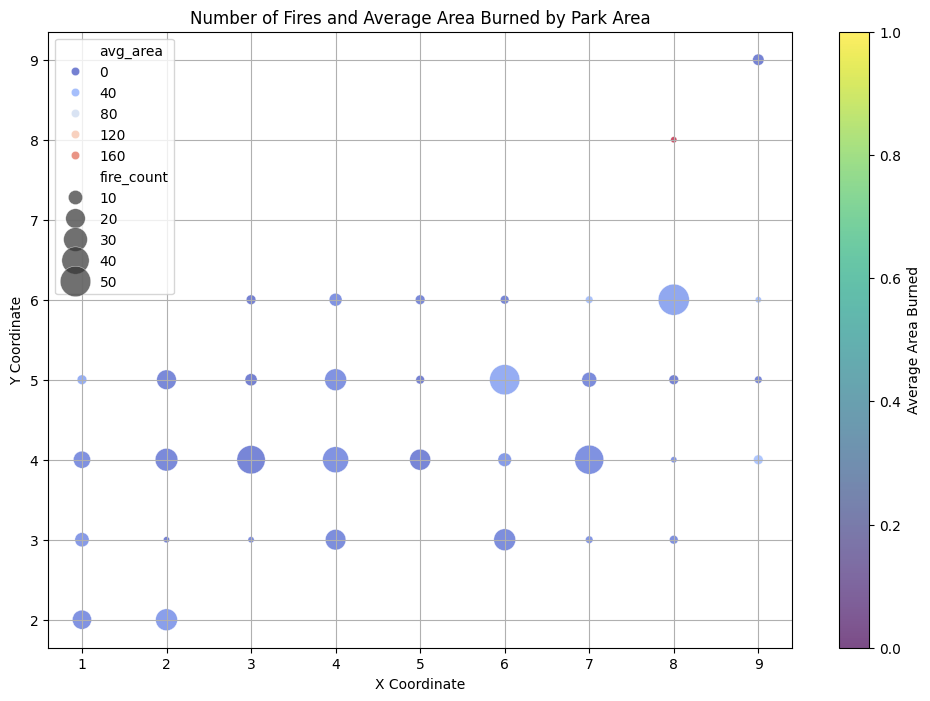

In [3]:
fires_count_area = forest_fires.groupby(["X", "Y"]).agg(
    fire_count=("area", "count"),
    avg_area=("area", "mean")
).reset_index()

plt.figure(figsize=(12, 8))

# Graphique de dispersion
scatter = sns.scatterplot(data=fires_count_area, x="X", y="Y", 
                          size="fire_count", sizes=(20, 500), 
                          hue="avg_area", palette="coolwarm", 
                          alpha=0.7, edgecolor="w")

plt.colorbar(scatter.collections[0], label="Average Area Burned")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Number of Fires and Average Area Burned by Park Area")
plt.grid(True)
plt.show()

In [4]:
forest_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Nous voyons ici les types de données pour chaque variable. En somme, elles sont toutes numériques, sauf le  mois (month), le jour (day) et la position (X et Y), qui sont catégoriques. Effectivement, vu que les variables X et Y définissent une position dans le parc, nous les considérons comme catégoriques, même si elles ont le type "int64" dans la sortie ci-dessus.

In [5]:
forest_fires.describe()

X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655818  
min      2.200000   15.000000    0.400000    0.000000     0.000000  
25%     15.500000   33.000000    2.700000    0.000000     0.000000  
50%     19.300000   42.000000    4.000000    0.000000     0.520000  
75%     22.800000   53.000000    4.900000    0.000000     6.570000  
max     33.300000  100.000000    9.400000    6.400000  1090.840000

In [6]:
forest_fires['rain'].value_counts()

rain
0.0    509
0.2      2
0.8      2
1.0      1
6.4      1
0.4      1
1.4      1
Name: count, dtype: int64

Nous avons décidé d'exclure le facteur **pluie** dans l'apprentissage de notre modèle afin d'améliorer sa performance. En effet, la majorité des lignes surviennent pour une pluviométrie nulle. L'étude ne sera donc pas impactée. Effectivement, nous avons exécuté certaines parties de l'analyse en incluant le facteur **pluie**, ainsi que en l'excluant. En général, inclure ce facteur semble fausser les résultats, en les rendant moins intéressants. 
De plus, nous pensons que le jour de l'incendie n'est pas une information pertinente à prendre en compte dans notre contexte. Au contraire, des mois peuvent être associés à des saisons et donc à des facteurs métérologiques. Par exemple, le mois d'août est plus propice aux départs de feu, du fait de la sécheresse de l'été.

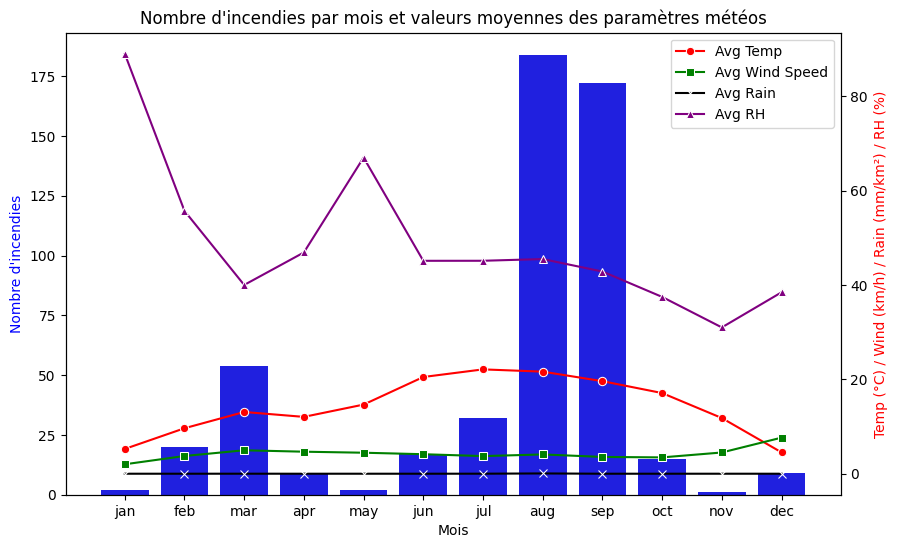

In [7]:
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
forest_fires["month"] = Categorical(forest_fires["month"], categories=month_order, ordered=True)

fires_per_month = forest_fires["month"].value_counts().sort_index()
avg_temp_per_month = forest_fires.groupby("month", observed=False)["temp"].mean().reindex(month_order)
avg_wind_per_month = forest_fires.groupby("month", observed=False)["wind"].mean().reindex(month_order)
avg_rain_per_month = forest_fires.groupby("month", observed=False)["rain"].mean().reindex(month_order)
avg_rh_per_month = forest_fires.groupby("month", observed=False)["RH"].mean().reindex(month_order)

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x=fires_per_month.index, y=fires_per_month.values, ax=ax1, order=month_order, color="b")
ax1.set_xlabel("Mois")
ax1.set_ylabel("Nombre d'incendies", color='b')
ax1.set_title("Nombre d'incendies par mois et valeurs moyennes des paramètres météos")

ax2 = ax1.twinx()

sns.lineplot(x=avg_temp_per_month.index, y=avg_temp_per_month.values, ax=ax2, color='r', marker='o', label="Avg Temp")
sns.lineplot(x=avg_wind_per_month.index, y=avg_wind_per_month.values, ax=ax2, color='g', marker='s', label="Avg Wind Speed")
sns.lineplot(x=avg_rain_per_month.index, y=avg_rain_per_month.values, ax=ax2, color='black', marker='x', label="Avg Rain")
sns.lineplot(x=avg_rh_per_month.index, y=avg_rh_per_month.values, ax=ax2, color='purple', marker='^', label="Avg RH")

ax2.set_ylabel("Temp (°C) / Wind (km/h) / Rain (mm/km²) / RH (%)", color='r')

ax2.legend(loc="upper right")

plt.show()

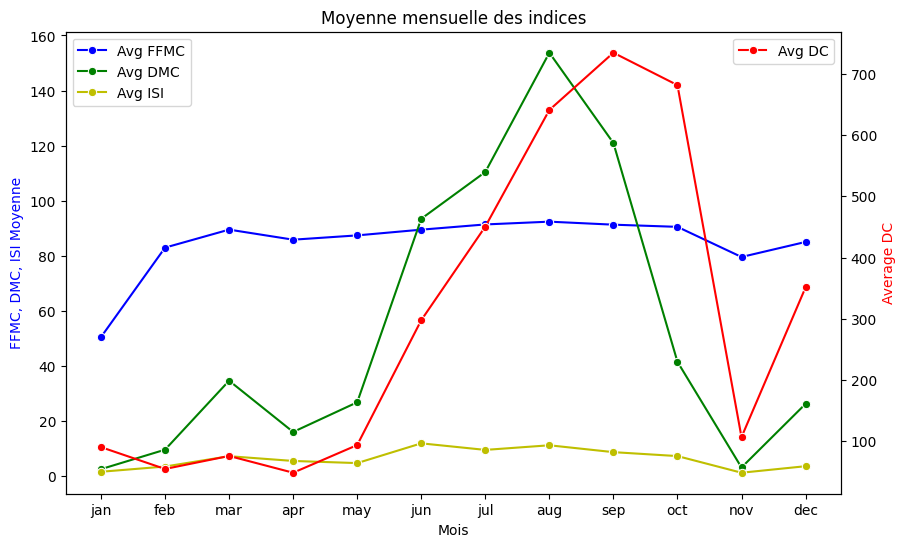

In [8]:

avg_ffmc_per_month = forest_fires.groupby("month", observed=False)["FFMC"].mean().reindex(month_order)
avg_dmc_per_month = forest_fires.groupby("month", observed=False)["DMC"].mean().reindex(month_order)
avg_dc_per_month = forest_fires.groupby("month", observed=False)["DC"].mean().reindex(month_order)
avg_isi_per_month = forest_fires.groupby("month", observed=False)["ISI"].mean().reindex(month_order)

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(x=avg_ffmc_per_month.index, y=avg_ffmc_per_month.values, ax=ax1, color='b', marker='o', label="Avg FFMC")
sns.lineplot(x=avg_dmc_per_month.index, y=avg_dmc_per_month.values, ax=ax1, color='g', marker='o', label="Avg DMC")
sns.lineplot(x=avg_isi_per_month.index, y=avg_isi_per_month.values, ax=ax1, color='y', marker='o', label="Avg ISI")

ax1.set_xlabel("Mois")
ax1.set_ylabel("FFMC, DMC, ISI Moyenne", color='b')
ax1.set_title("Moyenne mensuelle des indices")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
sns.lineplot(x=avg_dc_per_month.index, y=avg_dc_per_month.values, ax=ax2, color='r', marker='o', label="Avg DC")
ax2.set_ylabel("Average DC", color='r')
ax2.legend(loc="upper right")

plt.show()

# <font color='red'> Approche 1 </font> 

Dans cette approche, nous utilisons le **PCA** et le **k-means clustering** 

Il faut remarquer que nous ne pouvons faire le PCA qu'avec les données numériques, et afin d'atteindre les meilleurs résultats, nous nous sommes concentrés seulement sur les données continues; c'est-à-dire que nous avons supprimé toutes les variables catégoriques. 

In [9]:
# Tout d'abord il faut mettre à l'echelle les données.
numeric_values = forest_fires[numeric_fields].drop(columns=['rain'])

# Normalisation des variables numériques
scaler = StandardScaler()
scaled_continues = DataFrame(scaler.fit_transform(numeric_values), columns=numeric_values.columns)

scaled_continues.head()

FFMC       DMC        DC       ISI      temp        RH      wind
0 -0.805959 -1.323326 -1.830477 -0.860946 -1.842640  0.411724  1.498614
1 -0.008102 -1.179541  0.488891 -0.509688 -0.153278 -0.692456 -1.741756
2 -0.008102 -1.049822  0.560715 -0.509688 -0.739383 -0.692456 -1.518282
3  0.191362 -1.212361 -1.898266 -0.004756 -1.825402  3.233519 -0.009834
4 -0.243833 -0.931043 -1.798600  0.126966 -1.291012  3.356206 -1.238940

Text(0.5, 0, 'Nombre des composantes principales')

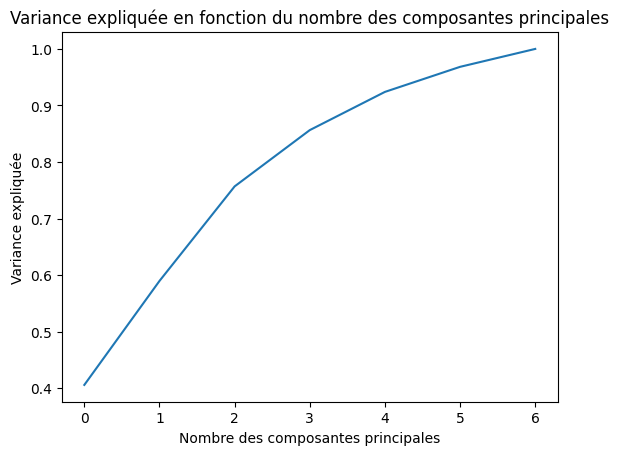

In [10]:
# Le PCA avec les données continues mises à l'echelle.
pca = PCA()
principal_components = pca.fit(scaled_continues)
plt.plot(cumsum(pca.explained_variance_ratio_))
plt.title("Variance expliquée en fonction du nombre des composantes principales")
plt.ylabel("Variance expliquée")
plt.xlabel("Nombre des composantes principales")

Nous pouvons voir ici qu'il faut 7 composantes principales pour expliquer 100% de la variance. Cependant, seulement 3 composantes principales expliquent plus de 80%. Ainsi, nous pouvons prendre ces 3 pour transformer l'espace.

In [11]:
# PCA avec n_components = 3
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_continues)

principal_df = DataFrame(data=principal_components, columns=['principal_component 1', 'principal_component 2', 'principal_component 3'])

principal_df.head()

principal_component 1  principal_component 2  principal_component 3
0              -3.211649              -0.779911               1.032113
1              -0.179110              -0.233692              -1.892423
2              -0.406577              -0.095672              -1.573137
3              -2.911734               1.025567               1.629800
4              -2.496005               1.542007               0.654077

Ci-dessus, nous exprimons les données en fonction des 3 composantes principales. Chaque ligne correspond à une ligne dans le tableau des données d'origine.

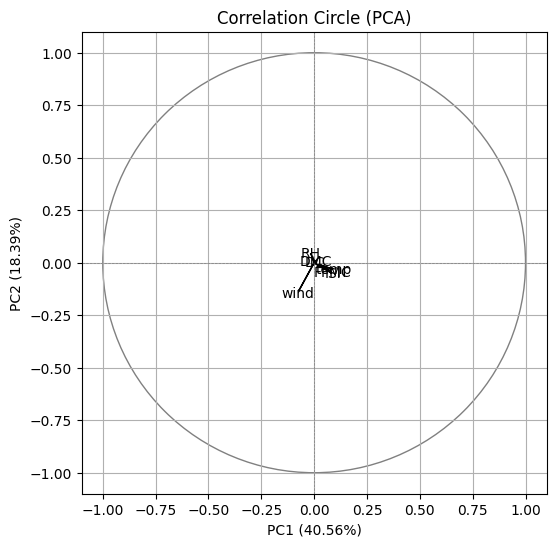

In [12]:

def display_correlation_circle(scaled_data, scaler_obj, pca_obj):
    correlations = dot(linalg.inv(diag(scaler_obj.scale_)), pca_obj.components_.T)
    correlations = correlations[:, :2]

    circle = plt.Circle((0, 0), 1, color='gray', fill=False)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.add_artist(circle)

    for i in range(len(scaled_data.columns)):
        column = scaled_data.columns[i]
        if column != 'Cluster':
            plt.arrow(0, 0, correlations[i, 0], correlations[i, 1],
                    head_width=0.005, head_length=0.005, color='black')
            plt.text(correlations[i, 0] * 1.1, correlations[i, 1] * 1.1,
                    scaled_data.columns[i], color='black', ha='center', va='center')
    x_lim = 1.1
    y_lim = x_lim
    plt.xlim(-x_lim, x_lim)
    plt.ylim(-y_lim, y_lim)
    plt.axhline(0, color='gray', linestyle='--', lw=0.5)
    plt.axvline(0, color='gray', linestyle='--', lw=0.5)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.title('Correlation Circle (PCA)')
    plt.grid()

    fig.show()

display_correlation_circle(scaled_continues, scaler, pca)

Ici, nous avons tracé le **cercle de corrélation** en utilisant les 2 premières composantes principales. Ce qui est évident, c'est que les variables n'approchent pas les bords du cercle. Puisque nous pouvons seulement interpréter les variables proches des limites du cercle, cela nous dit que l'espace de faible dimension n'est pas représentatif de la structure sous-jacente. Ainsi, il faut considérer d'autres méthodes.

Maintenant que nous avons exprimé les données dans espace de faible dimension, nous pouvons tenter de mieux les comprendre en faisant une classification à l'aide du **k-means clustering**.

## Silhouette

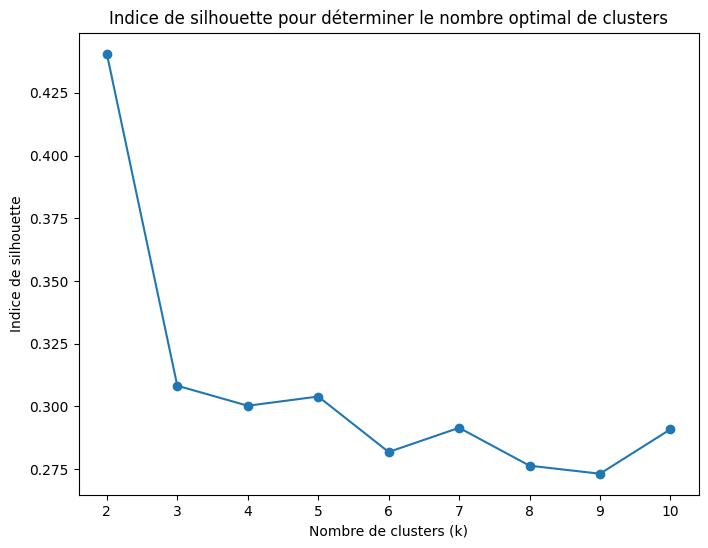

In [13]:
# Calculer l'indice de silhouette pour différents k
silhouette_scores = []
k_values = range(2, 11)  # L'indice de silhouette n'est pas calculé pour k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_df[['principal_component 1', 'principal_component 2', 'principal_component 3']])
    score = silhouette_score(principal_df[['principal_component 1', 'principal_component 2', 'principal_component 3']], kmeans.labels_)
    silhouette_scores.append(score)

# Tracer la courbe de l'indice de silhouette
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Indice de silhouette')
plt.title('Indice de silhouette pour déterminer le nombre optimal de clusters')
plt.show()

Ici, nous avons exécuté la technique de classification pour des valeurs différentes de k, ce qui nous permet d'évaluer chaque classification. Il est clair qu'une classification en 2 groupes obtient le meilleur coefficient de silhouette. Cependant, le coefficient de silouette est faible pour toute valeurs de k, ce qui nous dit qu'encore une fois que peut-être, la structure sous-jacente n'est pas bien représentée. 

In [14]:
# Définir le nombre de clusters (par exemple, 3)
kmeans = KMeans(n_clusters=2, random_state=42)

# Appliquer K-means sur les composantes principales
kmeans.fit(principal_df[['principal_component 1', 'principal_component 2', 'principal_component 3']])

# Ajouter les labels de cluster au DataFrame
principal_df['Cluster'] = kmeans.labels_


def display_pc3d(pc_data):
    # Visualiser les clusters en 3D
    fig = px.scatter_3d(
        pc_data,
        x=pc_data.columns[0],
        y=pc_data.columns[1],
        z=pc_data.columns[2],
        color='Cluster',  # Variable de couleur pour différencier les clusters
        labels={pc_data.columns[0]: 'PC 1', pc_data.columns[1]: 'PC 2', pc_data.columns[2]: 'PC 3'},
        opacity=0.7,
        title='Visualisation 3D des Clusters après PCA'
    )
    # Afficher la figure interactive
    fig.show()

display_pc3d(principal_df)

Ici, nous avons les données exprimées dans la base réduite colorées selon les groupes déterminés par l'algorithme de k-means. Nous pouvons identifier 2 groupes distincts, cepedendant il y a aussi certaines valeurs aberrantes dans chaque classe. Ce qui n'est pas évident à ce point de l'analyse, c'est d'interpréter les groupes. Dans quel sens ce groupes sont-ils liés aux données d'origine ? Y-a-t-il une interprétation physique que nous pouvons tirer ?

## Tracé des coordonnées parallèles

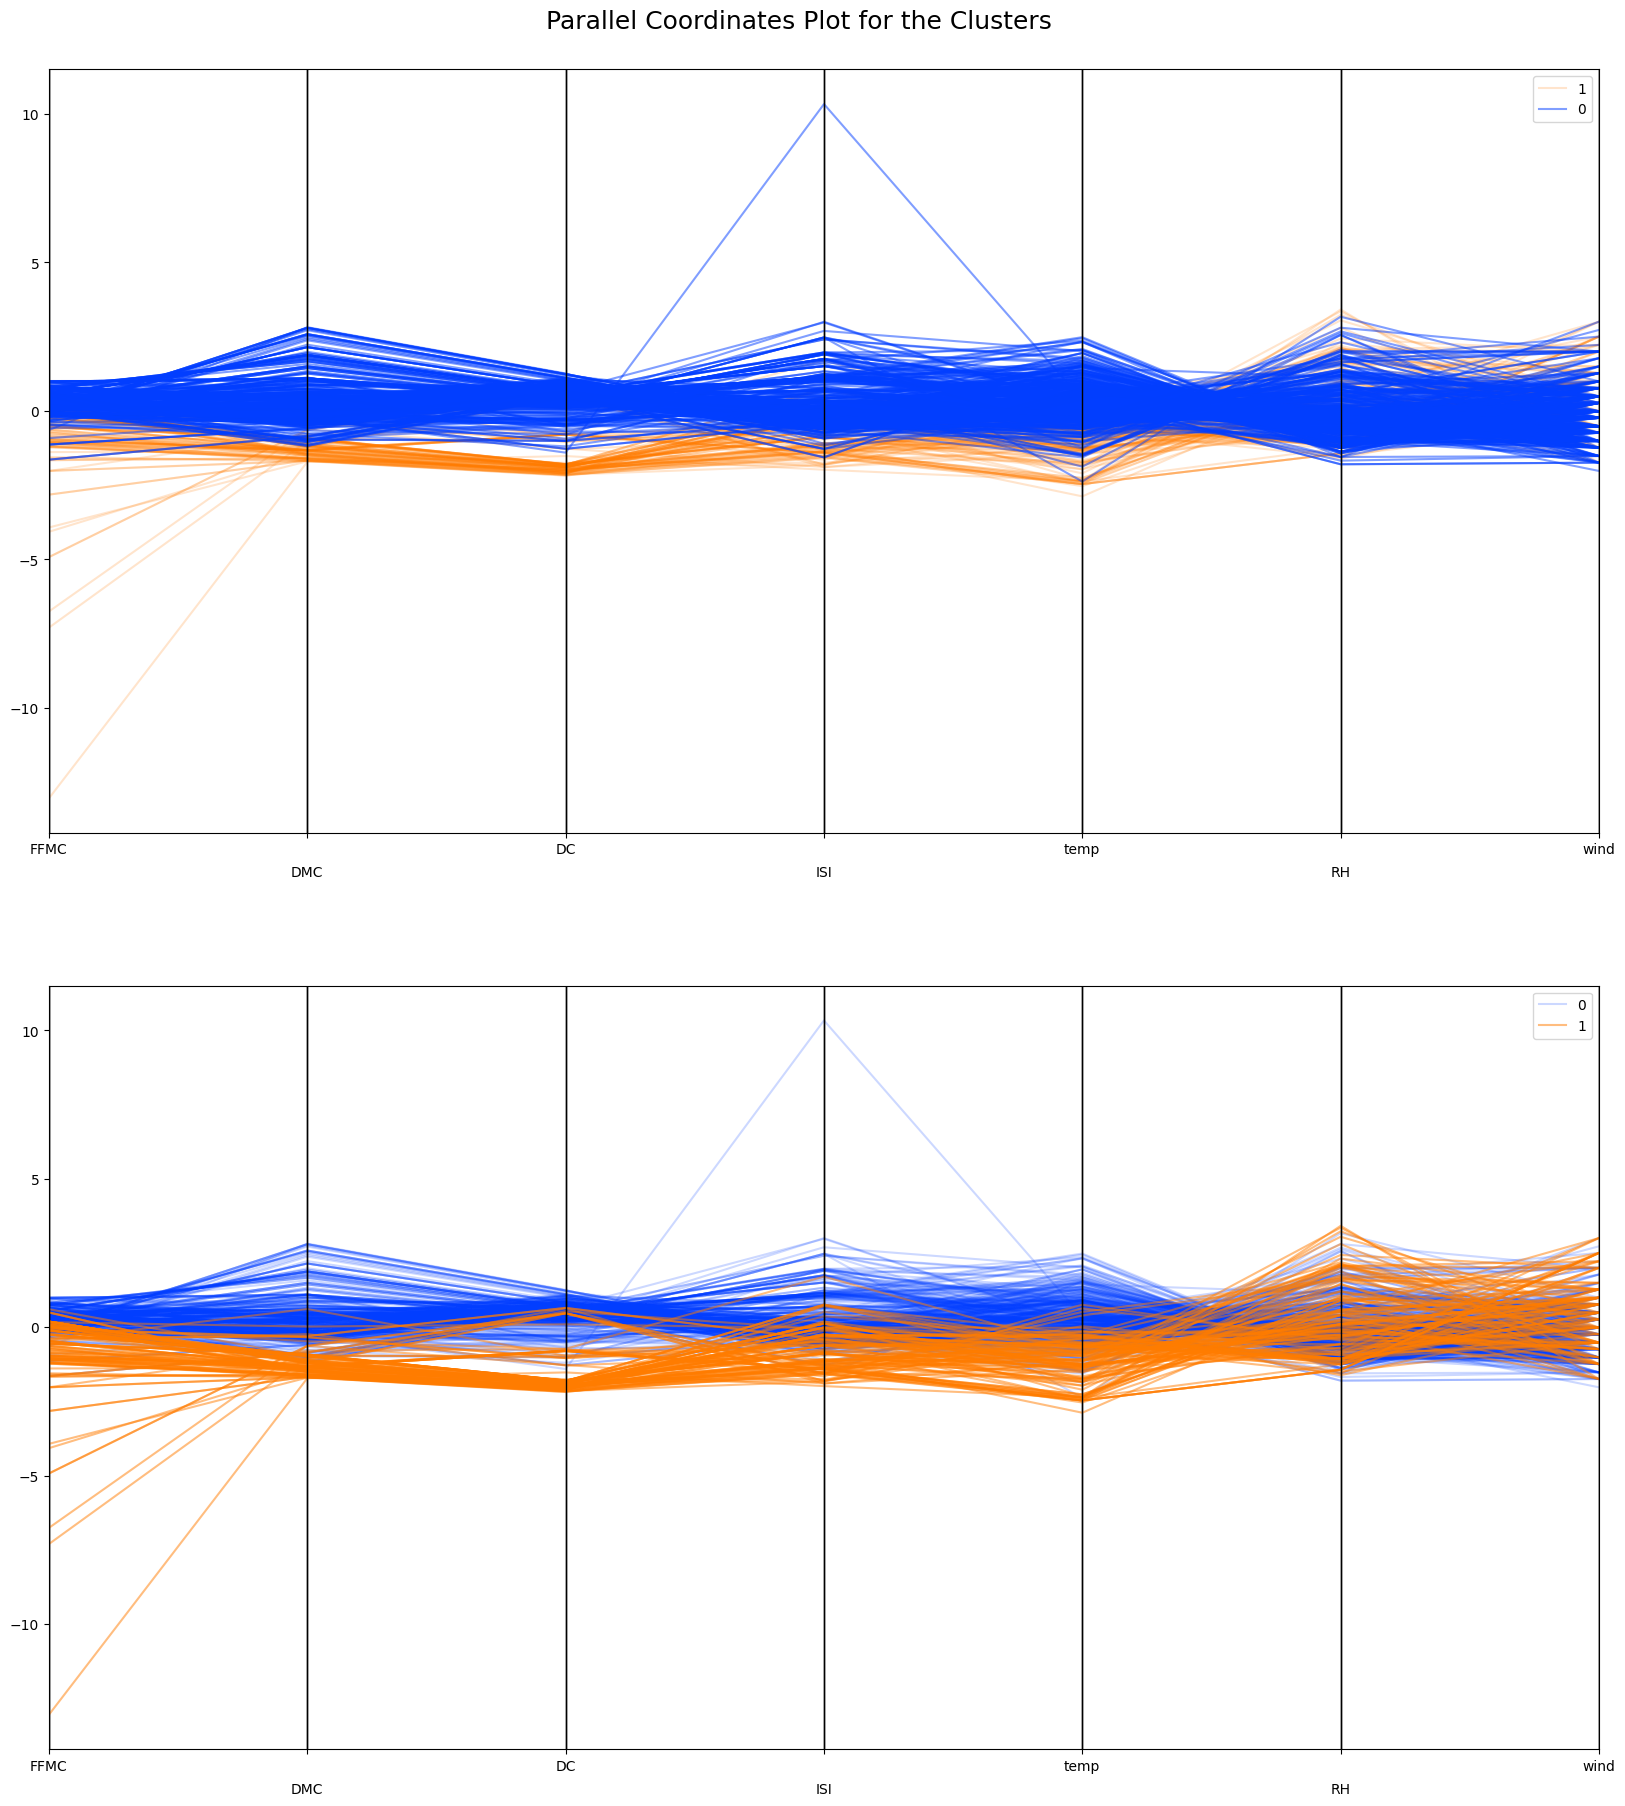

In [15]:
palette = sns.color_palette("bright", 10)

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''

    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.Cluster==i])

    # Create the plot
    fig = plt.figure(figsize=(20, 20))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points):
            if i!= j:
                pc = parallel_coordinates(c, 'Cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'Cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)


scaled_continues['Cluster'] = kmeans.labels_


n = len(scaled_continues['Cluster'].unique())
palette = sns.color_palette("bright", n)

display_parallel_coordinates(scaled_continues, n)

Ici nous avons tracé les coordonées parallèles, ce qui nous permet d'analyser les groupes de k-means et de mieux comprendre ce qu'ils représentent. Chaque ligne dans le graphique représente une ligne dans les données mises à l'echelle. L'axe X contient les valeurs d'entrée du PCA. Les valeurs de chaque variable sont représentées sur l'axe Y. Si les données ne sont pas mises à l'echelle, le graphique sera faussé et pourra aboutir à des conclusions fallacieuses. 

Nous pouvons voir que pour les variables de **RH** et **Wind**, les lignes de chaque groupe se chevauchent beaucoup. Cependant, pour les autres variables, surtout de **temp**, **DMC** et **DC**, nous voyons que les lignes sont plutôt étalées. La distinction n'est pas nette à 100%. Cependant, cette interprétation concorde bien avec ce que nous avons vu dans l'analyse exploratoire, qui montre le lien entre les incendies et les indices de DMC et DC.

# <font color='red'> Approche 2 </font>

Dans cette approche, nous traitons la possibilité que le PCA ne représente pas bien la structure sous-jacente. En particulier, le PCA est une méthode linéaire, et ainsi, ne marche pas très bien quand il y a une forte corrélation entre les variables. Pour cette raison, nous avons choisi d'utiliser le **t-SNE** (t-distributed stochastic neighbor embedding), qui est bien adapté à ce genre de situation.

Dans le PCA, les composantes principales sont des vecteurs sur lesquelles nous faisons des projections linéaires de nos données. Elles sont principales parce qu'elles maximisent la variance des données.

Dans le **t-SNE**, au lieu de maximiser la variance, elle vise à préserver les distances entres les points de données. En somme, les points qui sont proches les uns des autres dans les données brutes devraient être proches dans l'espace de faible dimension.

La méthode de **t-SNE** atteint son objectif en utilisant une distribution de probabilité conjointe. Plus précisément, l'algorithme de **t-SNE** définie une distribution conjointe pour chaque point dans l'espace d'origine tel que des points proches ont une forte probabilité d'être chosis comme voisins tandis que des points éloignés ont une faible probabilité d'être sélectionnés. Les distributions conjointes sont également définies de même manière dans l'espace de faible dimension.

Le but de l'algorithme consiste à faire concorder les deux densités de probabilité, l'une dans l'espace d'origine et l'autre dans l'espace de faible dimension. Effectivement, nous pouvons définir une mesure de dissimilarité entre deux distributions, par exemple, la divergence de Kullback-Leibler. Ainsi, en concordant deux densités, nous minimisons cette divergence.

Un paramètre très important dans cet algorithme est la perplexité. Celle-ci permet de configurer l'écart-type des distributions conjointes. En effet, plus l'écart-type est large, plus il est probable que deux points éloignés soient choisis comme voisins.

Pour faire la classification, nous avons choisi le modèle de **mélange gaussien**, qui est aussi bien adapté pour traiter les variables fortement corrélées. L'algorithme suppose que les données sont générées par plusieurs distributions gaussiennes. Donc, chaque point est associé à l'une des distributions. Chaque distribution 


Pour préparer la classification avec le modèle de **mélange gaussien**, il est important de s'assurer que les données suivent des distributions gaussiennes. Ainsi, pour mettre les données à l'échelle, nous avons utilisé la **transformation de puissance** (Power Transform), qui rend les données plus proches d'une distribution normale.

In [16]:
data_numeric = data[[*indices, *weather]].drop(columns=['rain'])

pt = PowerTransformer(method='yeo-johnson')
transformed_data = DataFrame(pt.fit_transform(data_numeric), columns=data_numeric.columns)

<Axes: title={'center': 't-SNE avec perplexité 40'}, xlabel='tsne_0', ylabel='tsne_1'>

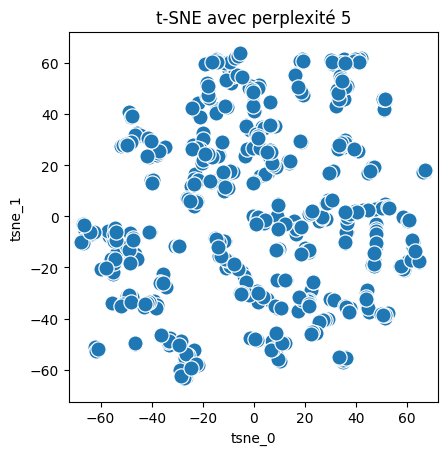

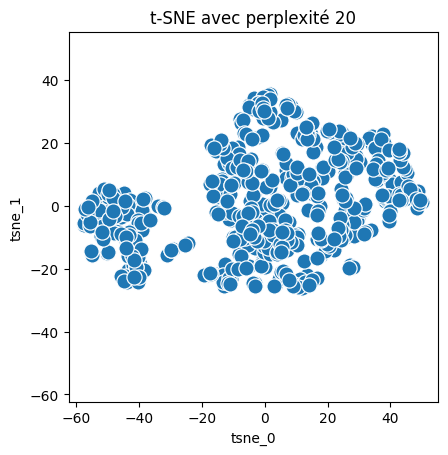

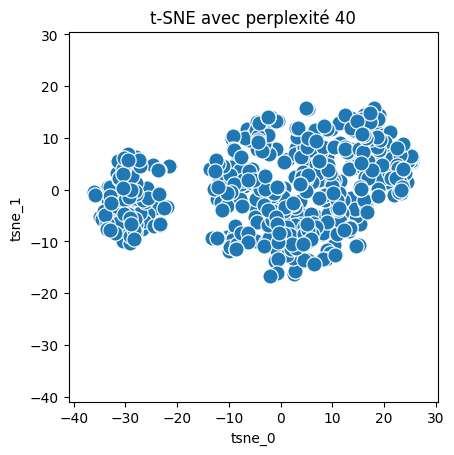

In [17]:
n_components = 2

def get_tsne_result(tsne_input_data, n_components, perplexity):
    tsne = TSNE(n_components, perplexity=perplexity)
    tsne_result = tsne.fit_transform(tsne_input_data)

    tsne_result_df = DataFrame({
        f'tsne_{i}': tsne_result[:,i] for i in range(n_components)
    })
    return tsne_result, tsne_result_df

def plot_tsne_output(tsne_result, tsne_result_df, perplexity):
    fig = figure()
    ax = fig.subplots()
    sns.scatterplot(x='tsne_0', y='tsne_1', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_title(f"t-SNE avec perplexité {perplexity}")
    ax.set_aspect('equal')
    return ax


tsne_result1, tsne_result_df1 = get_tsne_result(transformed_data, n_components, 5)
tsne_result2, tsne_result_df2 = get_tsne_result(transformed_data, n_components, 20)
tsne_result3, tsne_result_df3 = get_tsne_result(transformed_data, n_components, 40)

plot_tsne_output(tsne_result1, tsne_result_df1, 5)
plot_tsne_output(tsne_result2, tsne_result_df2, 20)
plot_tsne_output(tsne_result3, tsne_result_df3, 40)

Nous pouvons remarquer ici que plus nous agrandissons la perplexité, plus nous pouvons identifier des groupes nets. Ainsi, nous choisissons de prendre une perplexité de 40.

Text(0.5, 1.0, 'Indice de silhouette pour déterminer le nombre optimal de clusters')

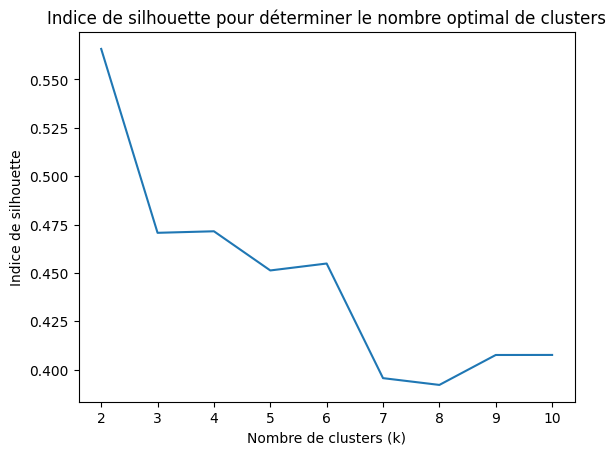

In [18]:
range_n_clusters = range(2,11)
sils = []
for n in range_n_clusters:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(tsne_result3)
    cluster_labels = gmm.predict(tsne_result_df3.values)
    silhouette_avg = silhouette_score(tsne_result_df3, cluster_labels)

    sils.append(silhouette_avg)
plt.plot(range_n_clusters, sils)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Indice de silhouette')
plt.title('Indice de silhouette pour déterminer le nombre optimal de clusters')

Encore une fois, nous avons utilisé le coefficient de silhouette pour évaluer la qualité de chaque classification. Une classification en 2 groupes obtient le meilleur résultat pour cette approche.

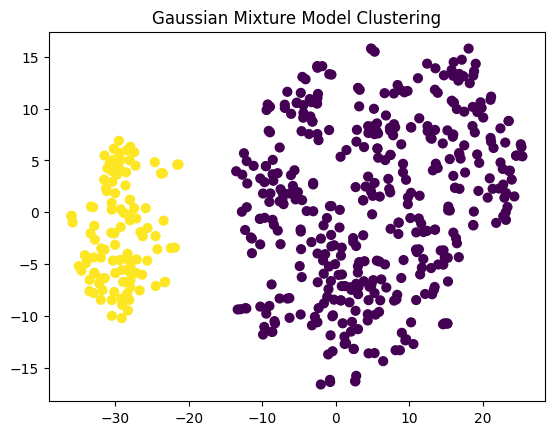

In [19]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(tsne_result_df3)
cluster_labels = gmm.predict(tsne_result_df3)

tsne_result_df3['Cluster'] = cluster_labels

plt.scatter(tsne_result3[:, 0], tsne_result3[:, 1], c=cluster_labels, s=40, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering')
plt.show()


On identifie par le modèle de clustering de **Gaussian Mixture** les 2 clusters.

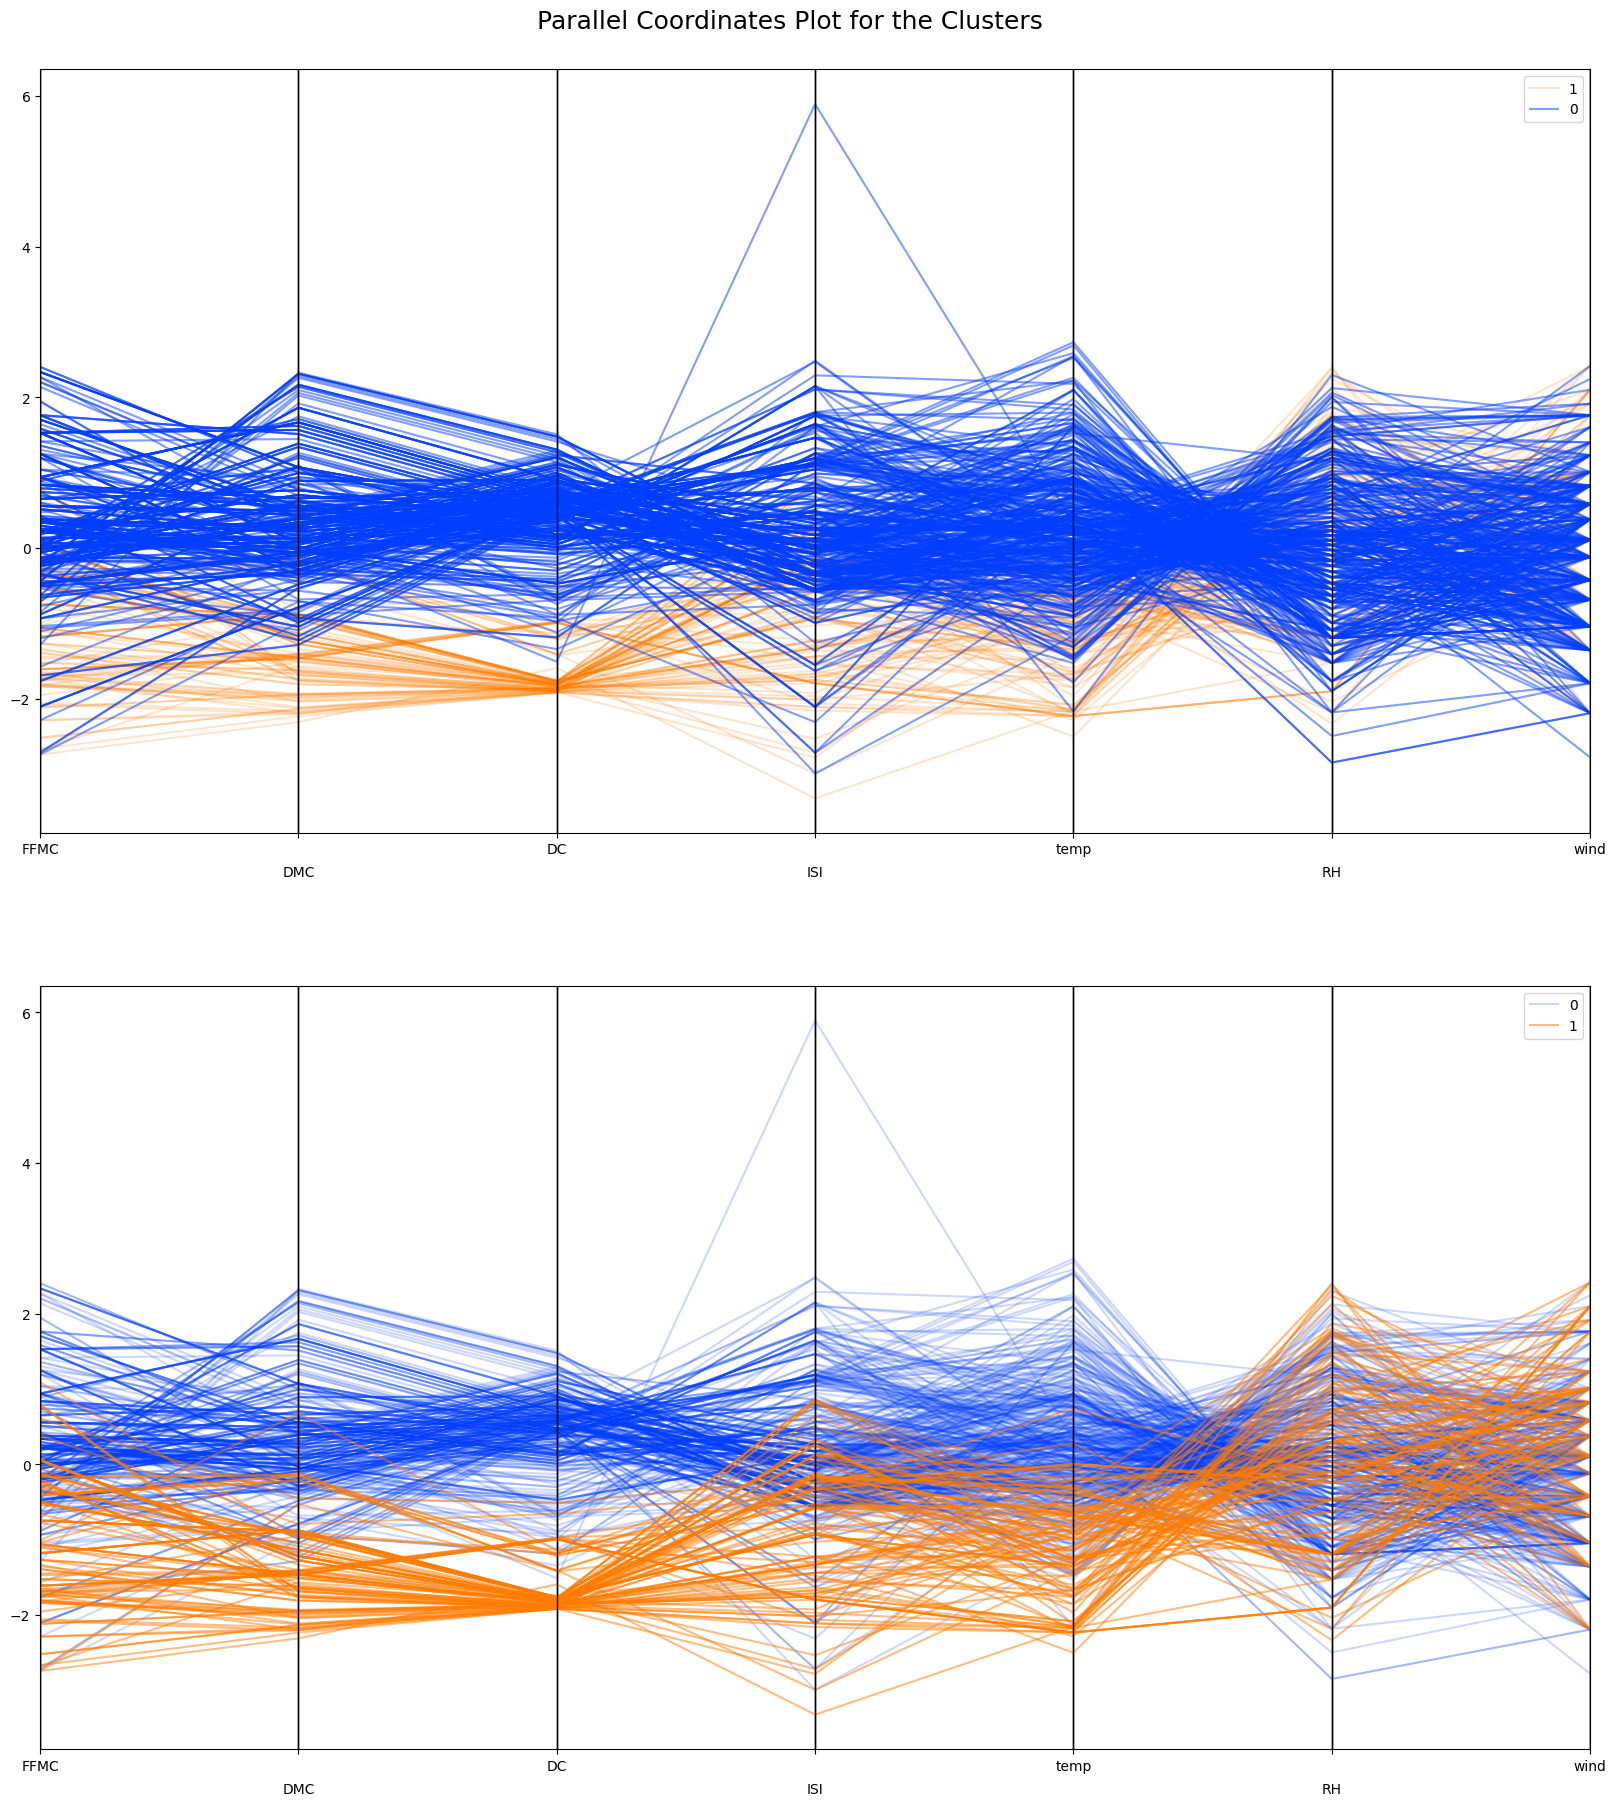

In [20]:
transformed_data['Cluster'] = cluster_labels

n = len(transformed_data['Cluster'].unique())
palette = sns.color_palette("bright", n)

display_parallel_coordinates(transformed_data, n)

Pour interpréter les resultats de la classification dans cette approche, nous avons aussi tracé les coordonées parallèles. Nous pouvons tirer une interprétation similaire, qui montre que les facteurs DC et la température sont les plus influents.

# <font color='red'> Approche 3 </font>

Dans cette approche, nous nous concentrons sur les mois de l'année comme variable catégorique. Pour traiter les variables catégoriques, il faut faire le **one-hot encoding**, ce qui est fait au-dessous. Puisque le **one-hot encoding** crée une nouvelle variable pour chaque valeur distincte dans le colonne catégorique, la dimensionalité du jeu de données peut augmementer rapidement. Par exemple, la colonne de mois contient 12 valeurs différents, et ainsi 12 nouvelles colonnes seraient créées. Le **one-hot encoding** crée de nouvelles colonnes 'saisons' avec pour données des 0 et des 1 pour transformer les données catégoriques en données numériques.

Donc, afin de minimiser l'augmentation de la dimensionalité, ce qui peut créer des problèmes avec certaines méthodes de machine learning, nous divisons les mois dans les saisons différentes. Cela porte aussi une interprétation physique, puisque nous prévoyons que les saisons les plus chaudes possèdent plus d'incendies.

In [21]:
forest_fires = data.copy()
seasons = {
    'jan': 'winter',
    'feb': 'winter',
    'mar': 'winter',
    'apr': 'spring',
    'may': 'spring',
    'jun': 'spring',
    'jul': 'summer',
    'aug': 'summer',
    'sep': 'summer',
    'oct': 'autumn',
    'nov': 'autumn',
    'dec': 'autumn'
}
forest_fires['season'] = forest_fires['month'].map(seasons)

In [22]:
season_column = ['season']

# Hot encoding
categorical_data = forest_fires[season_column]
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(categorical_data)

encoded_df = DataFrame(
    onehot_encoded,
    columns=encoder.get_feature_names_out(season_column)
)

numerical_data = data[[*indices, *weather]]

full_encoded_data = concat([numerical_data, encoded_df], axis=1).drop(columns=['rain'])

full_encoded_data.head()

FFMC   DMC     DC  ISI  temp  RH  wind  season_autumn  season_spring  \
0  86.2  26.2   94.3  5.1   8.2  51   6.7            0.0            0.0   
1  90.6  35.4  669.1  6.7  18.0  33   0.9            1.0            0.0   
2  90.6  43.7  686.9  6.7  14.6  33   1.3            1.0            0.0   
3  91.7  33.3   77.5  9.0   8.3  97   4.0            0.0            0.0   
4  89.3  51.3  102.2  9.6  11.4  99   1.8            0.0            0.0   

   season_summer  season_winter  
0            0.0            1.0  
1            0.0            0.0  
2            0.0            0.0  
3            0.0            1.0  
4            0.0            1.0

In [23]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(full_encoded_data)
scaled_data_df = DataFrame(scaled_data, columns=full_encoded_data.columns)

scaled_data_df.head()

FFMC       DMC        DC       ISI      temp        RH      wind  \
0 -0.805959 -1.323326 -1.830477 -0.860946 -1.842640  0.411724  1.498614   
1 -0.008102 -1.179541  0.488891 -0.509688 -0.153278 -0.692456 -1.741756   
2 -0.008102 -1.049822  0.560715 -0.509688 -0.739383 -0.692456 -1.518282   
3  0.191362 -1.212361 -1.898266 -0.004756 -1.825402  3.233519 -0.009834   
4 -0.243833 -0.931043 -1.798600  0.126966 -1.291012  3.356206 -1.238940   

   season_autumn  season_spring  season_summer  season_winter  
0      -0.225417       -0.23929      -1.734287       2.408865  
1       4.436215       -0.23929      -1.734287      -0.415133  
2       4.436215       -0.23929      -1.734287      -0.415133  
3      -0.225417       -0.23929      -1.734287       2.408865  
4      -0.225417       -0.23929      -1.734287       2.408865

In [24]:
gow_dist_matrix = gower.gower_matrix(scaled_data_df)

On utilise la distance de *Gower* pour calculer des distances pour des données catégoriques.

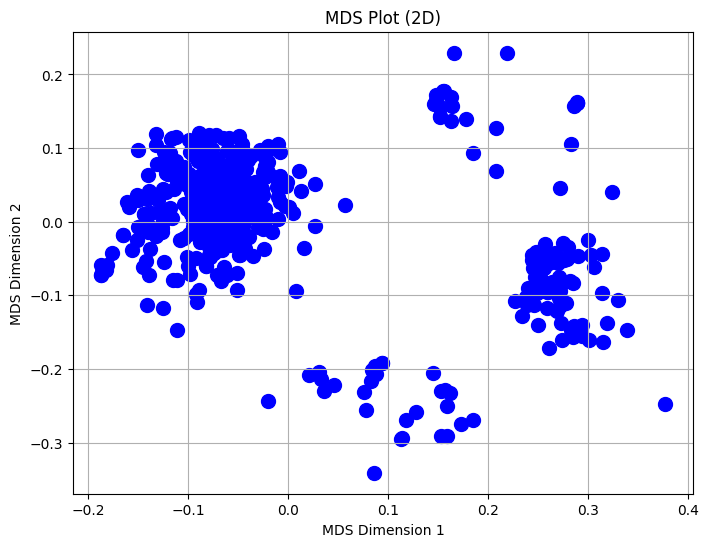

In [25]:


# Appliquer MDS sur la matrice de distance de Gower
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_results = mds.fit_transform(gow_dist_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(mds_results[:, 0], mds_results[:, 1], c='blue', s=100)

plt.title('MDS Plot (2D)')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()

Pour la méthode de réduction de dimensionalité, nous avons exécuté le **MDS** (Multidimensional scaling), qui est une méthode non linéaire. Il y a plusieurs types de **MDS**, et le défaut donné par la librairie de sklearn est le mMDS (Metric multidimensional scaling). Comme données d'entrées, elle accepte une matrice de distance, ce qui est dans ce cas la matrice de distances de *Gower* que nous avons calculé ci-dessus. 

L'algorithme tente de placer les points dans un espace de dimension inférieure tout en conservant autant que possible les distances entre eux. 

Pour y arriver, l'algorithme utilise un "stress" pour mesurer les différences entre les distance dans l'espace d'origine et les distances dans l'espace de faible dimension. En effet, le stress est un indicateur de la qualité de la projection. Plus le stress est faible, plus les distances dans l'espace projeté ressemblent aux distances originales.

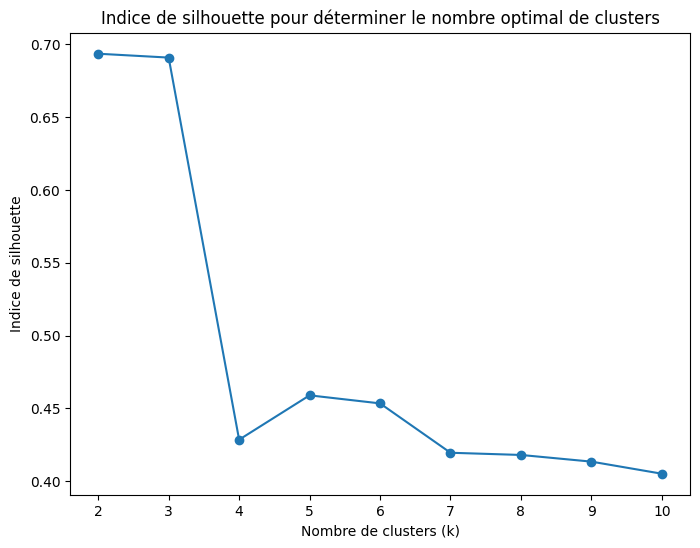

In [26]:



# Calculer l'indice de silhouette pour différents k
silhouette_scores = []
k_values = range(2, 11)  # L'indice de silhouette n'est pas calculé pour k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mds_results)
    score = silhouette_score(mds_results, kmeans.labels_)
    silhouette_scores.append(score)

# Tracer la courbe de l'indice de silhouette
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Indice de silhouette')
plt.title('Indice de silhouette pour déterminer le nombre optimal de clusters')
plt.show()


Le tracé précédent nous montre que l'indice de silhouette est le plus élevé pour 2 clusters.

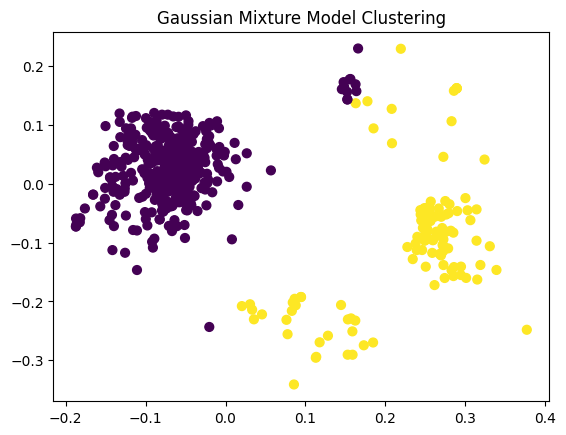

In [27]:
from sklearn.cluster import KMeans

n_clusters = 2

# Définir le nombre de clusters (par exemple, 3)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Appliquer K-means sur les composantes principales
kmeans.fit(mds_results)

# Ajouter les labels de cluster au DataFrame
scaled_data_df['Cluster'] = kmeans.labels_


plt.scatter(mds_results[:, 0], mds_results[:, 1], c=scaled_data_df['Cluster'], s=40, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering')
plt.show()


On utilise ici l'algorithme de **Gaussian Mixture** pour identifier les 2 clusters.

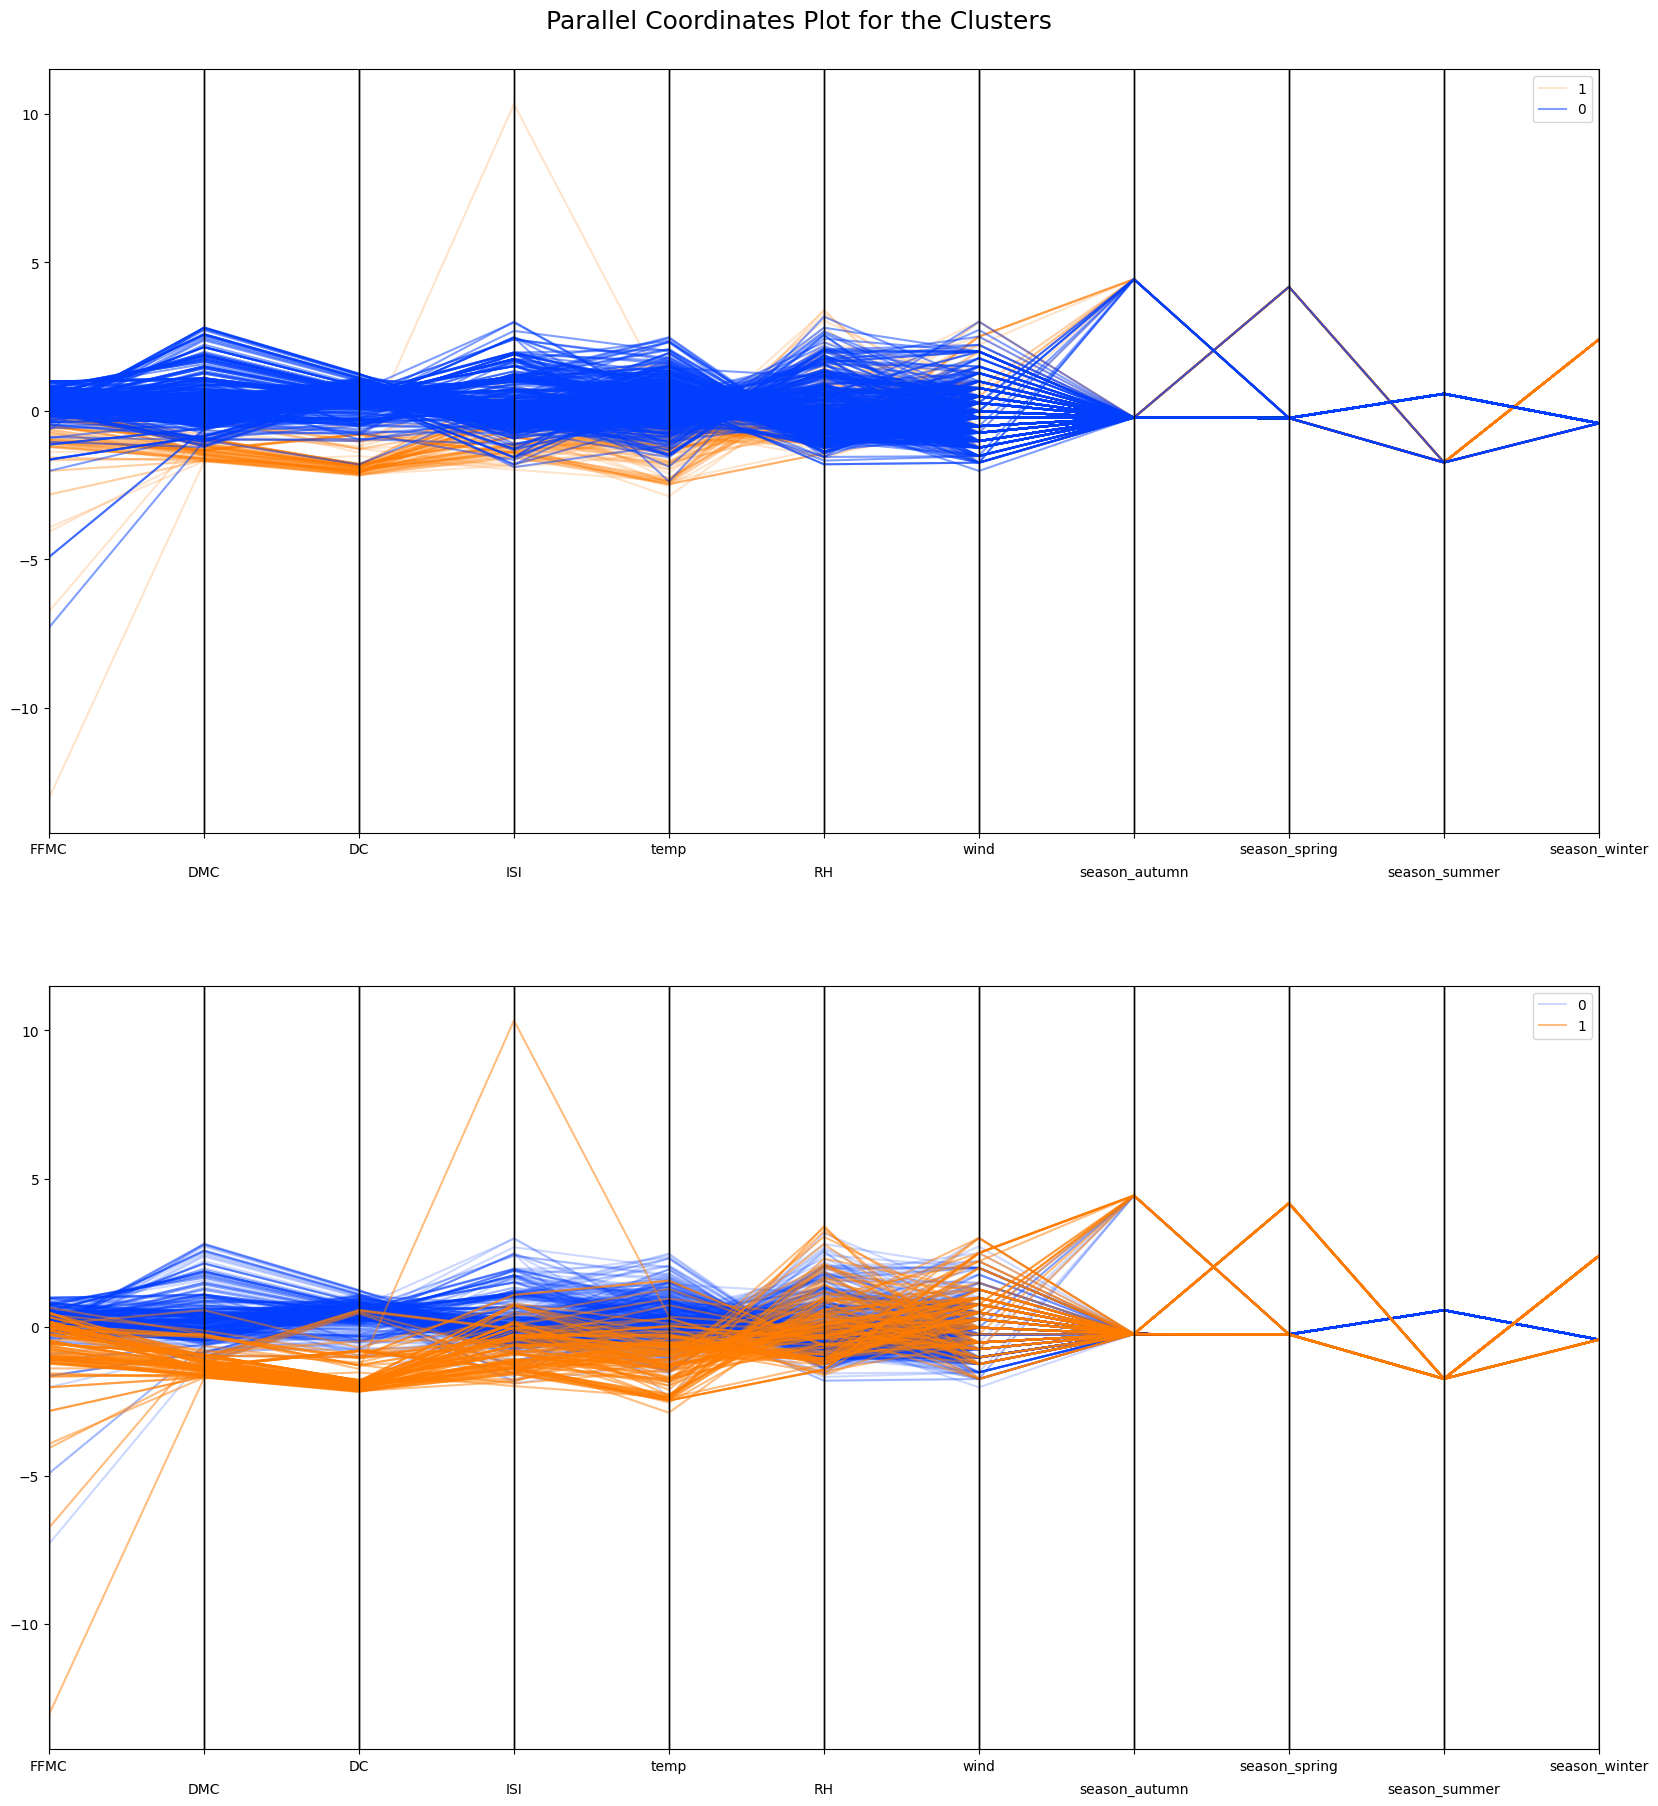

In [28]:

n = len(scaled_data_df['Cluster'].unique())
palette = sns.color_palette("bright", n)

display_parallel_coordinates(scaled_data_df, n)

Ci-dessus, nous avons le tracé des coordonnées parallèles, cette fois en incluant les saisons. Globalement, les résultats fournissent la même interprétation que les autres approches, puisque ce sont les indices qui différencient les groupes. Cependant, ce graphique révèle un autre facteur important : les saisons. En particulier, nous observons que toutes les lignes du premier groupe (en bleu) sont plus associées à l'été. En revanche, les lignes du deuxième groupe sont associées aux autres saisons. Ce résultat correspond bien à l'association entre l'été et les indices de feu, où le groupe lié à l'été est également associé à des indices de feu plus élevés.

En somme, les facteurs les plus impactants pour les feux de forêt dans la région de Montesinho sont le DC, le DMC et la saison de l'été. 